In [2]:
!pip install -q nnAudio
!pip install -q --upgrade wandb
!pip install -q grad-cam
!pip install -q ttach

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
earthengine-api 0.1.261 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
allennlp 2.3.0 requires wandb<0.11.0,>=0.10.0, but you have wandb 0.11.2 which is incompatible.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.20.53 which is incompatible.


# Data Loading

In [3]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
test = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

def get_train_file_path(image_id):
    return "../input/g2net-gravitational-wave-detection/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "../input/g2net-gravitational-wave-detection/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,id,target,file_path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...


,id,target,file_path
0,00005bced6,0.5,../input/g2net-gravitational-wave-detection/te...
1,0000806717,0.5,../input/g2net-gravitational-wave-detection/te...
2,0000ef4fe1,0.5,../input/g2net-gravitational-wave-detection/te...
3,00020de251,0.5,../input/g2net-gravitational-wave-detection/te...
4,00024887b5,0.5,../input/g2net-gravitational-wave-detection/te...


# Quick EDA

CQT kernels created, time used = 0.0339 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


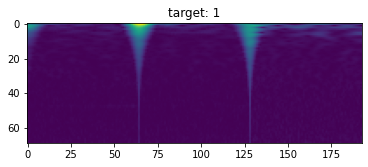

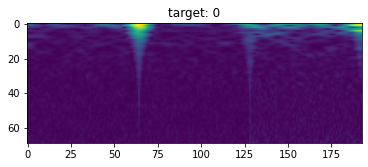

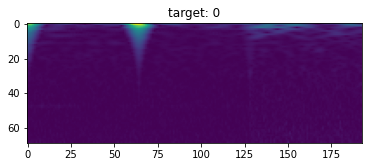

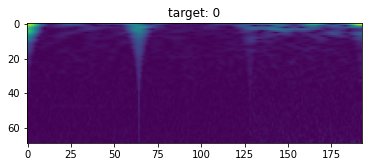

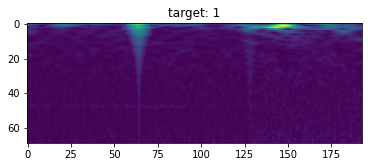

In [5]:
import torch
from nnAudio.Spectrogram import CQT1992v2

def apply_qtransform(waves, transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)):
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    return image

for i in range(5):
    waves = np.load(train.loc[i, 'file_path'])
    image = apply_qtransform(waves)
    target = train.loc[i, 'target']
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

<AxesSubplot:>

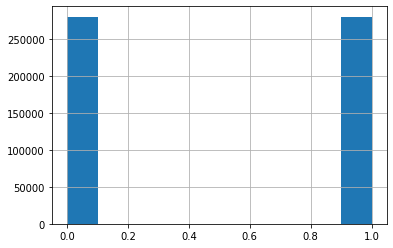

In [6]:
train['target'].hist()

# Directory settings

In [7]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [8]:
# ====================================================
# CFG
# ====================================================
class CFG:
    apex=False
    debug=False
    print_freq=100
    num_workers=4
    model_name='tf_efficientnet_b7_ns'
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=3
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=3 # CosineAnnealingLR
    #T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=48
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    qtransform_params={"sr": 2048, "fmin": 20, "fmax": 1024, "hop_length": 32, "bins_per_octave": 8}
    seed=42
    target_size=1
    target_col='target'
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True
    grad_cam=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=10000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")

In [11]:
import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="G2Net-Public-experiments", 
                 name="exp1",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yasufumi-nakama (use `wandb login --relogin` to force relogin)


# Utils

In [12]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [13]:
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

fold  target
0     0         56014
      1         55986
1     0         56014
      1         55986
2     0         56014
      1         55986
3     0         56014
      1         55986
4     0         56014
      1         55986
dtype: int64

# Dataset

In [14]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.wave_transform = CQT1992v2(**CFG.qtransform_params)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def apply_qtransform(self, waves, transform):
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        waves = np.load(file_path)
        image = self.apply_qtransform(waves, self.wave_transform)
        image = image.squeeze().numpy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label

In [15]:
class GradCAMDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_ids = df['id'].values
        self.file_names = df['file_path'].values
        self.labels = df[CFG.target_col].values
        self.wave_transform = CQT1992v2(**CFG.qtransform_params)
        self.transform = get_transforms(data='valid')
        
    def __len__(self):
        return len(self.df)
    
    def apply_qtransform(self, waves, transform):
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        file_path = self.file_names[idx]
        waves = np.load(file_path)
        image = self.apply_qtransform(waves, self.wave_transform)
        image = image.squeeze().numpy()
        vis_image = image.copy()
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image_id, image, vis_image, label

# Transforms

In [16]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

CQT kernels created, time used = 0.0092 seconds


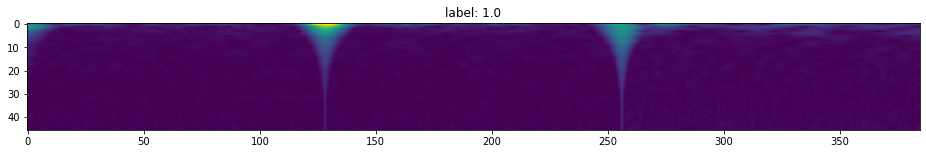

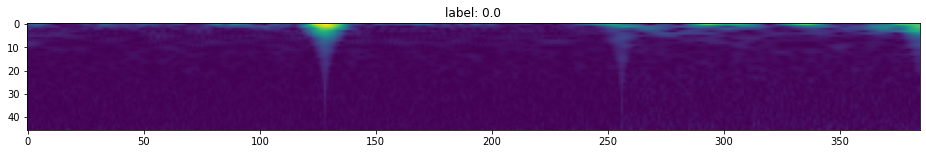

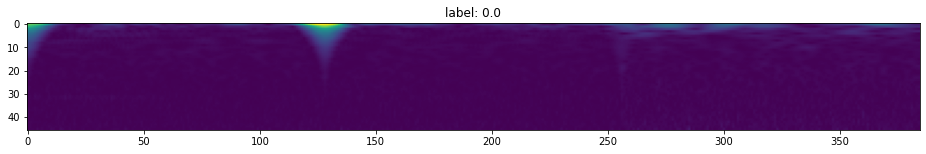

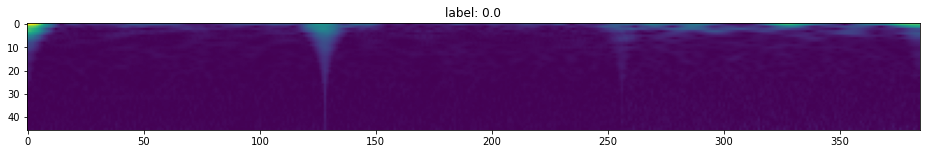

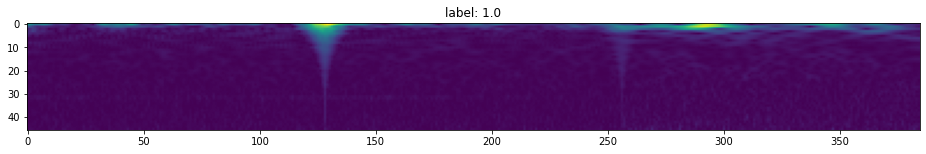

In [17]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(16,12))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# MODEL

In [18]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=1)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, self.cfg.target_size)

    def forward(self, x):
        output = self.model(x)
        return output

# Helper functions

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [20]:
def get_grad_cam(model, device, x_tensor, img, label, plot=False):
    
    result = {"vis": None, "img": None, "prob": None, "label": None}
    
    # model prob
    with torch.no_grad():
        prob = model(x_tensor.unsqueeze(0).to(device))
    prob = np.concatenate(prob.sigmoid().to('cpu').numpy())[0]
    
    # grad-cam
    target_layer = model.model.conv_head
    cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)
    output = cam(input_tensor=x_tensor.unsqueeze(0))
    try:
        vis = show_cam_on_image(x_tensor.numpy().transpose((1, 2, 0)), output[0])
    except:
        return result

    # plot result
    if plot:
        fig, axes = plt.subplots(figsize=(16, 12), ncols=2)
        axes[0].imshow(vis)
        axes[0].set_title(f"prob={prob:.4f}")
        axes[1].imshow(img)
        axes[1].set_title(f"target={label}")
        plt.show()
        
    result = {"vis": vis, "img": img, "prob": prob, "label": label}

    return result

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    if CFG.grad_cam:
        N = 5
        wandb_table = wandb.Table(columns=["id", "target", "prob", "image", "grad_cam_image"])
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                # load model
                model = CustomModel(CFG, pretrained=False)
                state = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                   map_location=torch.device('cpu'))['model']
                model.load_state_dict(state)
                model.to(device)
                model.eval()
                # load oof
                oof = pd.read_csv(OUTPUT_DIR+'oof_df.csv')
                oof = oof[oof['fold'] == fold].reset_index(drop=True)
                # grad-cam (oof ascending=False)
                count = 0
                oof = oof.sort_values('preds', ascending=False)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["prob"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= N:
                        break
                # grad-cam (oof ascending=True)
                count = 0
                oof = oof.sort_values('preds', ascending=True)
                valid_dataset = GradCAMDataset(oof)
                for i in range(len(valid_dataset)):
                    image_id, x_tensor, img, label = valid_dataset[i]
                    result = get_grad_cam(model, device, x_tensor, img, label, plot=True)
                    if result["vis"] is not None:
                        count += 1
                        wandb_table.add_data(image_id, 
                                             result["label"], 
                                             result["prob"], 
                                             wandb.Image(result["img"]), 
                                             wandb.Image(result["vis"]))
                    if count >= N:
                        break
        wandb.log({'grad_cam': wandb_table})
    
    wandb.finish()

========== fold: 0 training ==========


CQT kernels created, time used = 0.0133 seconds
CQT kernels created, time used = 0.0134 seconds


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b7_ns-1dbc32de.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b7_ns-1dbc32de.pth


Epoch: [1][0/9333] Elapsed 0m 4s (remain 698m 45s) Loss: 0.6976(0.6976) Grad: 2.3651  LR: 0.000100  
Epoch: [1][100/9333] Elapsed 1m 26s (remain 131m 42s) Loss: 0.5353(0.6163) Grad: 3.3846  LR: 0.000100  
Epoch: [1][200/9333] Elapsed 2m 48s (remain 127m 18s) Loss: 0.4930(0.5738) Grad: 2.1249  LR: 0.000100  
Epoch: [1][300/9333] Elapsed 4m 9s (remain 124m 35s) Loss: 0.4772(0.5527) Grad: 1.3315  LR: 0.000100  
Epoch: [1][400/9333] Elapsed 5m 31s (remain 123m 2s) Loss: 0.5162(0.5400) Grad: 1.5145  LR: 0.000100  
Epoch: [1][500/9333] Elapsed 6m 52s (remain 121m 7s) Loss: 0.5881(0.5318) Grad: 1.3546  LR: 0.000100  
Epoch: [1][600/9333] Elapsed 8m 12s (remain 119m 10s) Loss: 0.4237(0.5259) Grad: 0.9094  LR: 0.000100  
Epoch: [1][700/9333] Elapsed 9m 33s (remain 117m 42s) Loss: 0.3897(0.5201) Grad: 0.8395  LR: 0.000100  
Epoch: [1][800/9333] Elapsed 10m 54s (remain 116m 15s) Loss: 0.4606(0.5154) Grad: 1.1320  LR: 0.000100  
Epoch: [1][900/9333] Elapsed 12m 16s (remain 114m 52s) Loss: 0.5444(0

Epoch 1 - avg_train_loss: 0.4559  avg_val_loss: 0.4891  time: 8561s


EVAL: [1166/1167] Elapsed 15m 35s (remain 0m 0s) Loss: 0.4620(0.4891) 


Epoch 1 - Score: 0.8536
Epoch 1 - Save Best Score: 0.8536 Model
Epoch 1 - Save Best Loss: 0.4891 Model


Epoch: [2][0/9333] Elapsed 0m 3s (remain 489m 3s) Loss: 0.5547(0.5547) Grad: 0.4233  LR: 0.000057  
Epoch: [2][100/9333] Elapsed 1m 29s (remain 136m 26s) Loss: 0.4556(0.4394) Grad: 0.4322  LR: 0.000057  
Epoch: [2][200/9333] Elapsed 2m 55s (remain 132m 48s) Loss: 0.4822(0.4347) Grad: 0.5222  LR: 0.000057  
Epoch: [2][300/9333] Elapsed 4m 20s (remain 130m 8s) Loss: 0.5205(0.4291) Grad: 0.5419  LR: 0.000057  
Epoch: [2][400/9333] Elapsed 5m 45s (remain 128m 5s) Loss: 0.4113(0.4314) Grad: 0.5452  LR: 0.000057  
Epoch: [2][500/9333] Elapsed 7m 9s (remain 126m 12s) Loss: 0.4625(0.4329) Grad: 0.5802  LR: 0.000057  
Epoch: [2][600/9333] Elapsed 8m 32s (remain 124m 12s) Loss: 0.4290(0.4310) Grad: 0.7324  LR: 0.000057  
Epoch: [2][700/9333] Elapsed 9m 57s (remain 122m 33s) Loss: 0.4881(0.4304) Grad: 0.5014  LR: 0.000057  
Epoch: [2][800/9333] Elapsed 11m 20s (remain 120m 48s) Loss: 0.5403(0.4314) Grad: 0.6774  LR: 0.000057  
Epoch: [2][900/9333] Elapsed 12m 43s (remain 119m 3s) Loss: 0.4122(0.4

Epoch 2 - avg_train_loss: 0.4295  avg_val_loss: 0.4490  time: 8653s
Epoch 2 - Score: 0.8602
Epoch 2 - Save Best Score: 0.8602 Model


EVAL: [1166/1167] Elapsed 15m 2s (remain 0m 0s) Loss: 0.4073(0.4490) 


Epoch 2 - Save Best Loss: 0.4490 Model


Epoch: [3][0/9333] Elapsed 0m 3s (remain 586m 30s) Loss: 0.4441(0.4441) Grad: 0.3511  LR: 0.000009  
Epoch: [3][100/9333] Elapsed 1m 26s (remain 132m 8s) Loss: 0.4304(0.4193) Grad: 0.5528  LR: 0.000009  
Epoch: [3][200/9333] Elapsed 2m 48s (remain 127m 52s) Loss: 0.4916(0.4142) Grad: 0.6279  LR: 0.000009  
Epoch: [3][300/9333] Elapsed 4m 10s (remain 125m 23s) Loss: 0.4594(0.4158) Grad: 0.4695  LR: 0.000009  
Epoch: [3][400/9333] Elapsed 5m 32s (remain 123m 30s) Loss: 0.3521(0.4179) Grad: 0.5775  LR: 0.000009  
Epoch: [3][500/9333] Elapsed 6m 54s (remain 121m 55s) Loss: 0.3527(0.4192) Grad: 0.3162  LR: 0.000009  
Epoch: [3][600/9333] Elapsed 8m 16s (remain 120m 18s) Loss: 0.3846(0.4178) Grad: 0.5865  LR: 0.000009  
Epoch: [3][700/9333] Elapsed 9m 38s (remain 118m 44s) Loss: 0.4040(0.4183) Grad: 0.6319  LR: 0.000009  
Epoch: [3][800/9333] Elapsed 10m 59s (remain 117m 6s) Loss: 0.4233(0.4181) Grad: 0.6359  LR: 0.000009  
Epoch: [3][900/9333] Elapsed 12m 22s (remain 115m 47s) Loss: 0.5255(

Epoch 3 - avg_train_loss: 0.4134  avg_val_loss: 0.4279  time: 8551s
Epoch 3 - Score: 0.8611
Epoch 3 - Save Best Score: 0.8611 Model


EVAL: [1166/1167] Elapsed 15m 21s (remain 0m 0s) Loss: 0.3540(0.4279) 


Epoch 3 - Save Best Loss: 0.4279 Model
========== fold: 0 result ==========
Score: 0.8611
========== CV ==========
Score: 0.8611


CQT kernels created, time used = 0.0195 seconds


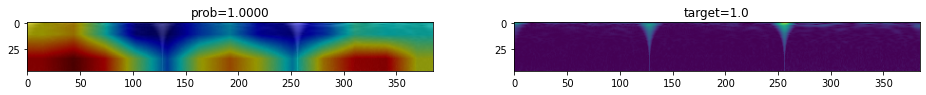

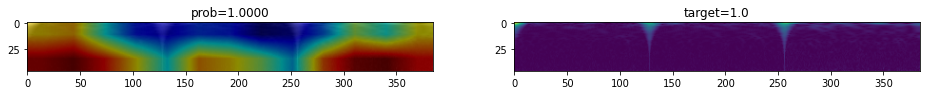

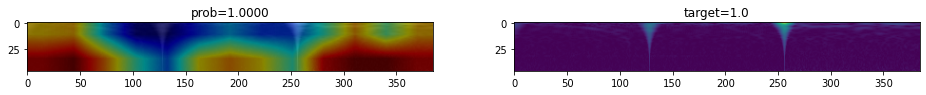

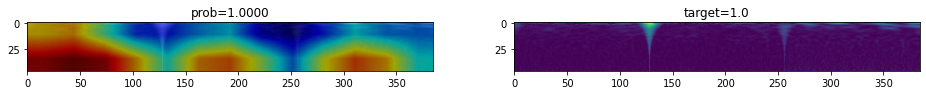

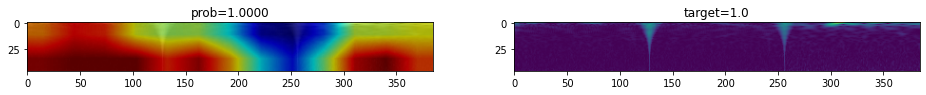

CQT kernels created, time used = 0.0095 seconds


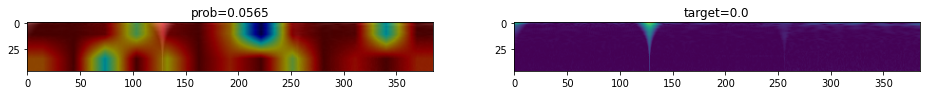

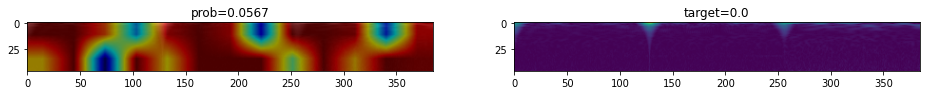

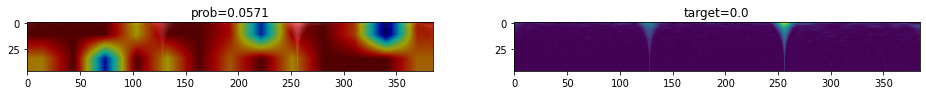

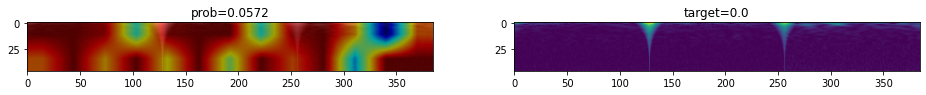

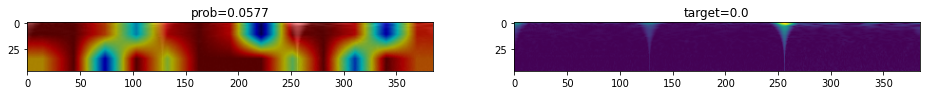

[fold0] loss,0.43781
[fold0] lr,1e-05
_runtime,25809
_timestamp,1628066129
_step,28002
[fold0] epoch,3
[fold0] avg_train_loss,0.41336
[fold0] avg_val_loss,0.42793
[fold0] score,0.86108


[fold0] loss,▆▃▆▅▄▂▄▄▃▄▄▇▅▃▄▂█▆▇▄▃█▅▇▃▅▃▇▁▃▄▃▂▃▄▁▅▅▂▃
[fold0] lr,█████████████▅▅▅▅▅▅▅▅▅▅▅▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
[fold0] epoch,▁▅█
[fold0] avg_train_loss,█▄▁
[fold0] avg_val_loss,█▃▁
[fold0] score,▁▇█


In [23]:
if __name__ == '__main__':
    main()